<a href="https://colab.research.google.com/github/pk-790324/Tensor-Flow-Series/blob/main/CNN/age_gender_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install opendatasets

In [7]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jangedoo/utkface-new')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pappuyadav0324
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


100%|██████████| 331M/331M [00:06<00:00, 55.6MB/s]


In [8]:
folder_path='/content/utkface-new/utkface_aligned_cropped/UTKFace'

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [11]:
df=pd.DataFrame({'age':age,'gender':gender,'img_path':img_path})

In [12]:
df.head()

,age,gender,img_path
0,7,1,7_1_1_20170113000913057.jpg.chip.jpg
1,29,0,29_0_2_20170116172041615.jpg.chip.jpg
2,50,0,50_0_3_20170119205145375.jpg.chip.jpg
3,27,1,27_1_2_20170116165601873.jpg.chip.jpg
4,45,0,45_0_1_20170117190019363.jpg.chip.jpg


In [13]:
df.shape

(23708, 3)

In [14]:
#splitting data for train,test and validation
train_data=df.sample(frac=1,random_state=0).iloc[:20000]
test_data=df.sample(frac=1,random_state=0).iloc[20000:22000]
val_data=df.sample(frac=1,random_state=0).iloc[22000:]

In [15]:
train_data.shape,test_data.shape,val_data.shape

((20000, 3), (2000, 3), (1708, 3))

In [16]:
#apply data agumentation
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)
val_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
train_generator=train_datagen.flow_from_dataframe(train_data,
                                                  directory=folder_path,
                                                  x_col='img_path',
                                                  y_col=['age','gender'],
                                                  target_size=(200,200),
                                                  class_mode='multi_output',
                                                  shuffle=True,
                                                  )
test_generator=test_datagen.flow_from_dataframe(test_data,
                                                directory=folder_path,
                                                x_col='img_path',
                                                y_col=['age','gender'],
                                                target_size=(200,200),
                                                class_mode='multi_output',
                                                shuffle=True)
val_generator=val_datagen.flow_from_dataframe(val_data,
                                                directory=folder_path,
                                                x_col='img_path',
                                                y_col=['age','gender'],
                                                target_size=(200,200),
                                                class_mode='multi_output',
                                                shuffle=True)

def generator_with_dict_output(generator):
    for x, y in generator:
        yield x, {'age': y[0], 'gender': y[1]}

train_generator_dict = generator_with_dict_output(train_generator)
test_generator_dict = generator_with_dict_output(test_generator)
val_generator_dict = generator_with_dict_output(val_generator)

Found 20000 validated image filenames.
Found 2000 validated image filenames.
Found 1708 validated image filenames.


In [18]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [19]:
#import vgg16
vggnet=VGG16(include_top=False,input_shape=(200,200,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [20]:
vggnet.trainable=False
output=vggnet.layers[-1].output
flatten=Flatten()(output)
dense1=Dense(512,activation='relu')(flatten)
dense2=Dense(512,activation='relu')(flatten)

dense3=Dense(512,activation='relu')(dense1)
dense4=Dense(512,activation='relu')(dense2)

output1=Dense(1,activation='linear',name='age')(dense3)
output2=Dense(1,activation='sigmoid',name='gender')(dense4)

In [21]:
model=Model(inputs=vggnet.input,outputs=[output1,output2])

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

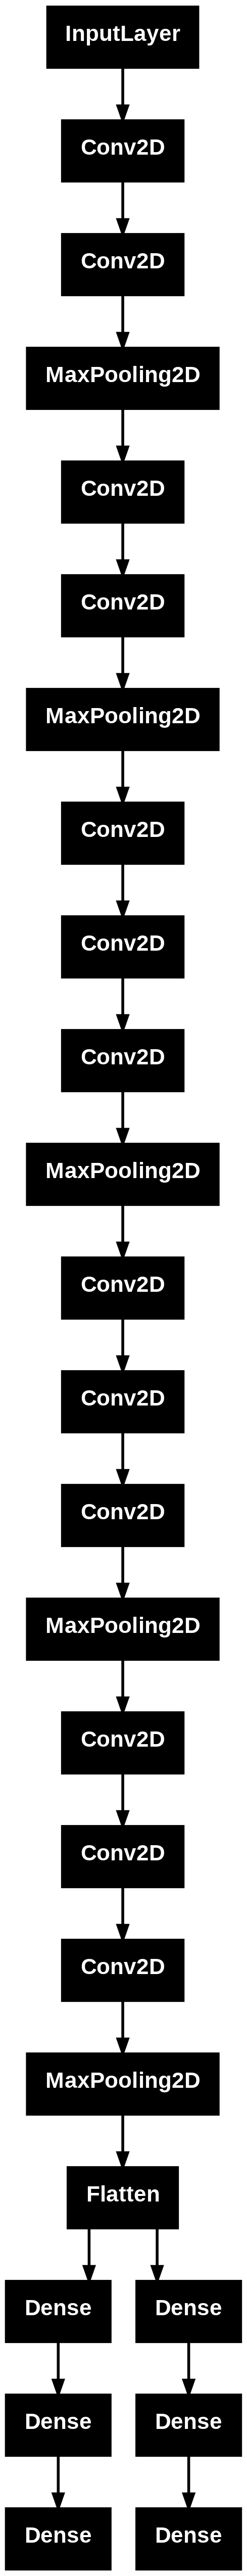

In [23]:
from keras.utils import plot_model
plot_model(model)


In [24]:
#compile the model
optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'},loss_weights={'age':1,'gender':99})

In [26]:
#fit the model
history=model.fit(train_generator_dict, epochs=5, steps_per_epoch=train_generator.samples // train_generator.batch_size, validation_data=val_generator_dict, validation_steps=val_generator.samples // val_generator.batch_size)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - age_loss: 9.4542 - age_mae: 9.4542 - gender_accuracy: 0.7876 - gender_loss: 0.4478 - loss: 53.7907 - val_age_loss: 8.3010 - val_age_mae: 8.3010 - val_gender_accuracy: 0.8526 - val_gender_loss: 0.3207 - val_loss: 40.0471
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 372ms/step - age_loss: 9.1877 - age_mae: 9.1877 - gender_accuracy: 0.8002 - gender_loss: 0.4224 - loss: 51.0033 - val_age_loss: 8.6714 - val_age_mae: 8.6714 - val_gender_accuracy: 0.8691 - val_gender_loss: 0.3111 - val_loss: 39.4741
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 382ms/step - age_loss: 8.8333 - age_mae: 8.8333 - gender_accuracy: 0.8120 - gender_loss: 0.3976 - loss: 48.1989 - val_age_loss: 8.2921 - val_age_mae: 8.2930 - val_gender_accuracy: 0.8592 - val_gender_loss: 0.3062 - val_loss: 38.7042
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - age_loss: 8.5614 - age_mae: 8.5614 - gender_accuracy: 0.8148 - gender_loss: 0.3935 - loss: 47.5156 - val_age_los

<Axes: >

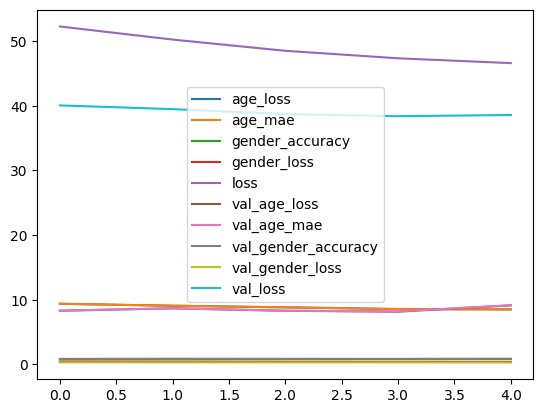

In [28]:
pd.DataFrame(history.history).plot()
